In [1]:
%matplotlib inline
import numpy as np
import keras
import keras.backend as K
from functools import reduce

import matplotlib.pyplot as plt

from keras.models         import Sequential
from keras.models         import Model
from keras.layers         import Dense
from keras.layers         import Convolution2D
from keras.layers         import AveragePooling2D
from keras.layers         import MaxPooling2D
from keras.layers         import UpSampling2D
from keras.layers         import Reshape
from keras.layers         import Flatten
from keras.metrics        import mse
from keras.optimizers     import Adam
from keras.utils.np_utils import to_categorical

path_to_fashion_mnist = '../../datasets/fashion-mnist/'

import sys
sys.path.insert(0, path_to_fashion_mnist)
from utils import mnist_reader

Using TensorFlow backend.


In [2]:
encoding_size = 10
batch_size    = 64

In [3]:
X_train, y_train = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 'train')
X_train          = X_train.reshape(-1, 28, 28, 1)
X_train          = (X_train - X_train.mean()) / X_train.std()
y_train          = to_categorical(y_train)

In [4]:
encoder = Sequential([
    Convolution2D(32, 3, padding = 'same', input_shape = (28, 28, 1), activation = 'relu'),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),    
    Flatten(),
    Dense(encoding_size, activation = 'tanh')
])

In [5]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,), activation = 'relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    Convolution2D(1, 3, padding = 'same', activation = 'tanh')
])

In [6]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(Adam(1e-4), loss = 'mse')

In [7]:
classifier = Sequential([
    Convolution2D(64, 3, padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
    MaxPooling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    Flatten(),
    Dense(10,  activation = 'softmax')
])
classifier.compile(Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
last_convolution_layer = classifier.layers[2]
perceptual_part        = Model(classifier.input, last_convolution_layer.output)

In [9]:
classifier_fit_params = {
    'x'              : X_train,
    'y'              : y_train,
    'epochs'         : 20,
    'batch_size'     : batch_size,
}

In [10]:
classifier.fit(**classifier_fit_params)

Epoch 1/20
60000/60000 [==============================] - 30s - loss: 0.5207 - acc: 0.8204    
Epoch 2/20
60000/60000 [==============================] - 28s - loss: 0.3530 - acc: 0.8752    
Epoch 3/20
60000/60000 [==============================] - 28s - loss: 0.3156 - acc: 0.8891    
Epoch 4/20
60000/60000 [==============================] - 28s - loss: 0.2903 - acc: 0.8976    
Epoch 5/20
60000/60000 [==============================] - 28s - loss: 0.2728 - acc: 0.9036    
Epoch 6/20
60000/60000 [==============================] - 28s - loss: 0.2575 - acc: 0.9083    
Epoch 7/20
60000/60000 [==============================] - 28s - loss: 0.2432 - acc: 0.9139    
Epoch 8/20
60000/60000 [==============================] - 28s - loss: 0.2321 - acc: 0.9178    
Epoch 9/20
60000/60000 [==============================] - 28s - loss: 0.2229 - acc: 0.9207    
Epoch 10/20
60000/60000 [==============================] - 28s - loss: 0.2126 - acc: 0.9244    
Epoch 11/20
60000/60000 [========================

In [11]:
classifier.trainable = False
for layer in classifier.layers:
    layer.trainable = False

In [21]:
perceptual_model = Sequential([
    autoencoder,
    perceptual_part
])
perceptual_model.compile(Adam(1e-4), loss = 'mse')

In [13]:
y_train_perceptual = perceptual_part.predict(X_train, batch_size = batch_size)

In [19]:
perceptual_model_fit_params = {
    'x'         : X_train,
    'y'         : y_train_perceptual,
    'batch_size': batch_size,
    'epochs'    : 30
}

In [22]:
perceptual_model.fit(**perceptual_model_fit_params)

Epoch 1/30
60000/60000 [==============================] - 102s - loss: 0.0545   
Epoch 2/30
60000/60000 [==============================] - 102s - loss: 0.0332   
Epoch 3/30
60000/60000 [==============================] - 102s - loss: 0.0300   
Epoch 4/30
60000/60000 [==============================] - 102s - loss: 0.0285   
Epoch 5/30
60000/60000 [==============================] - 102s - loss: 0.0275   
Epoch 6/30
60000/60000 [==============================] - 102s - loss: 0.0267   
Epoch 7/30
60000/60000 [==============================] - 102s - loss: 0.0261   
Epoch 8/30
60000/60000 [==============================] - 102s - loss: 0.0257   
Epoch 9/30
60000/60000 [==============================] - 102s - loss: 0.0253   
Epoch 10/30
60000/60000 [==============================] - 102s - loss: 0.0250   
Epoch 11/30
60000/60000 [==============================] - 102s - loss: 0.0247   
Epoch 12/30
60000/60000 [==============================] - 102s - loss: 0.0245   
Epoch 13/30
60000/60000 [

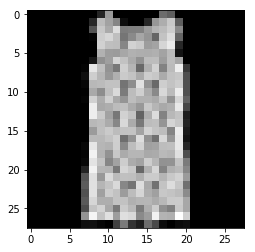

In [23]:
img = X_train[18]
plt.imshow(img.squeeze(), cmap = 'gray')

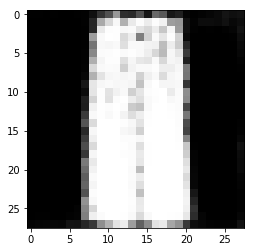

In [24]:
img_ = autoencoder.predict(np.expand_dims(img, 0))
plt.imshow(img_.squeeze(), cmap = 'gray')

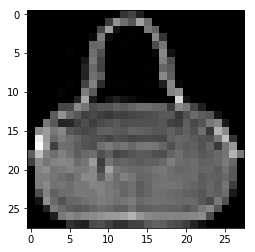

In [25]:
img = X_train[20]
plt.imshow(img.squeeze(), cmap = 'gray')

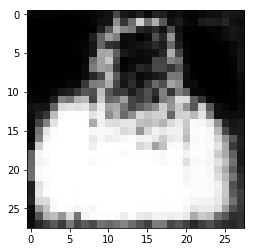

In [26]:
img_ = autoencoder.predict(np.expand_dims(img, 0))
plt.imshow(img_.squeeze(), cmap = 'gray')